In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

Read and clean the data

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1', usecols=['v1', 'v2'])
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#rename the columns
data.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Using binary classification for easy analysis on the label 
data['bin_tags'] = data['label'].apply(lambda label: 0 if label == 'ham' else 1)
data.head()

,label,message,bin_tags
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## EDA

Percentage of spams: 13.41%


Text(0.5, 1.0, 'Empirical distribution of the labels')

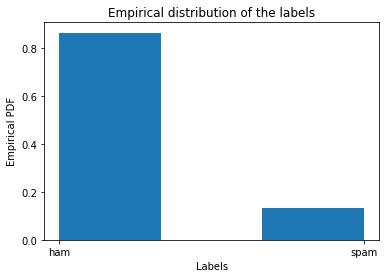

In [5]:
# Empirical distribution of the labels
print('Percentage of spams: {0}%'.format(round(100 * data['bin_tags'].sum() / len(data['bin_tags']), 2)))
plt.hist(data['label'], bins=3, weights=np.ones(len(data['label'])) / len(data['label']))
plt.xlabel('Labels')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')

For model's performance measure, it is strongly recommended to use F1-Score, because the distribution of the data showed an imbalance between HAM and SPAm messages

In [6]:
# extract spams and hams
spams = data['message'].iloc[(data['bin_tags'] == 1).values]
hams = data['message'].iloc[(data['bin_tags'] == 0).values]
print(spams[:10])
print(hams[:10])

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
12    URGENT! You have won a 1 week FREE membership ...
15    XXXMobileMovieClub: To use your credit, click ...
19    England v Macedonia - dont miss the goals/team...
34    Thanks for your subscription to Ringtone UK yo...
42    07732584351 - Rodger Burns - MSG = We tried to...
Name: message, dtype: object
0     Go until jurong point, crazy.. Available only ...
1                         Ok lar... Joking wif u oni...
3     U dun say so early hor... U c already then say...
4     Nah I don't think he goes to usf, he lives aro...
6     Even my brother is not like to speak with me. ...
7     As per your request 'Melle Melle (Oru Minnamin...
10    I'm gonna be home soon and i don't want to tal...
13    I've been sea

In [7]:
#Getting themessage lengths
data['message_len'] = data['message'].apply(len)
data.head()

,label,message,bin_tags,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

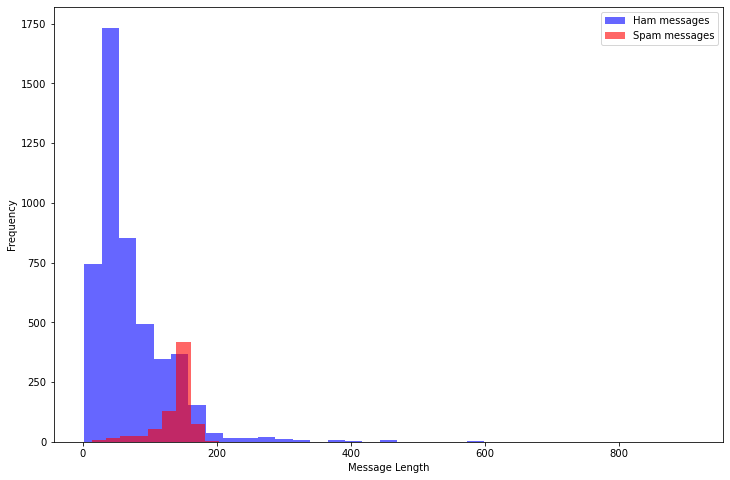

In [8]:
plt.figure(figsize=(12, 8))

data[data.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
data[data.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [9]:
#checking the highest length
data.message_len.max()

910

In [10]:
#let's play a little prank here
#let me locate this message, it might interest you to know what it contains
data[data.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [11]:
# most common words in spam and ham
spam_tokens = []
for spam in spams:
    spam_tokens += nltk.tokenize.word_tokenize(spam)
ham_tokens = []
for ham in hams:
    ham_tokens += nltk.tokenize.word_tokenize(ham)

print("Spam common words")
print(spam_tokens[:10])
print('Ham common words')
print(ham_tokens[:10])

Spam common words
['Free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'FA']
Ham common words
['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in']


In [12]:
# remove stop words and punctuation from tokens
stop_words = ['.', 'to', '!', ',', 'a', '&', 
              'or', 'the', '?', ':', 'is', 'for',
              'and', 'from', 'on', '...', 'in', ';',
              'that', 'of']
for tokens in [spam_tokens, ham_tokens]:
    for stop_word in stop_words:
        try:
            while True:
                tokens.remove(stop_word)
        except ValueError:  # all occurrences of the stop word have been removed
            pass

In [13]:
#locating the most common tokens in the labels
most_common_tokens_in_spams = Counter(spam_tokens).most_common(20)
most_common_tokens_in_hams = Counter(ham_tokens).most_common(20)

print('Spam')
print(most_common_tokens_in_spams, end='\n')
print('Ham')
print(most_common_tokens_in_hams)

Spam
[('you', 189), ('call', 187), ('your', 187), ('2', 176), ('now', 138), ('Call', 138), ('have', 129), ('4', 122), ('FREE', 115), ('*', 115), ('ur', 107), ('with', 102), ('mobile', 95), ('U', 89), ('You', 81), ('claim', 78), ('are', 77), ('our', 76), ('Txt', 75), ('To', 74)]
Ham
[('I', 1914), ('you', 1699), ('i', 937), ('u', 725), ('me', 719), ('..', 669), ('my', 623), ('it', 582), (')', 429), ("'s", 421), ("'m", 387), ('do', 376), ('your', 375), ('have', 366), ('not', 354), ("n't", 344), ('at', 338), ('are', 327), ('gt', 318), ('be', 316)]


The messages are now ready for vectorisation which prepares it for modelling